In [2]:
from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np
from numpy import array, zeros
from matplotlib import pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import math


# Chargement, clean et traitement des données

In [3]:
# Data cleaning and fitting
# retrive from here https://www.kaggle.com/datasets/stackoverflow/stacksample/data
raw_answers: DataFrame = read_csv('./data/Answers.csv', encoding='latin-1')
raw_questions: DataFrame = read_csv('./data/Questions.csv', encoding='latin-1')
raw_tags: DataFrame = read_csv('./data/Tags.csv', encoding='latin-1')
questions = raw_questions.copy()
answers = raw_answers.copy()
tags = raw_tags.copy()
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.reset_index()
tags = tags.groupby('Id')['Tag'].apply(list).reset_index()
questions = questions.join(tags['Tag'], on='Id')

# Keep only top 10 tags
top_tags = tags['Tag'].explode().value_counts().nlargest(10).index

# Drop NaN values
questions_top = questions.dropna(subset=['Tag'])


# Remove rows with tags not in top_tags
questions_top = questions_top[questions_top['Tag'].apply(lambda tags: any(tag in top_tags for tag in tags))]
questions_top.reset_index()
questions_top['CreationDate'] = pd.to_datetime(questions_top['CreationDate'])
questions_top['CreationDate'] = questions_top['CreationDate'].dt.date

# Patern frequent itemset

In [ ]:
# We compute patern frequent, and association rules

# Create a list of lists of tags for each question
# trans questions['Tag'] to list of string
freq_pat = questions['Tag'].dropna().tolist()
# print(freq_pat)
# freq_pat = [(str(element) for element in list_) for list_ in freq_pat]


# Step 1: Convert the dataset into a one-hot encoded DataFrame
te = TransactionEncoder()
te_data = te.fit(freq_pat).transform(freq_pat)
df = pd.DataFrame(te_data, columns=te.columns_)

# Step 2: Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True)

frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print(frequent_itemsets)


rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)

rules

Sub01ClusHTML

      support               itemsets
178  0.102421           (javascript)
175  0.088688                 (java)
46   0.077479                   (c#)
250  0.076153                  (php)
9    0.070420              (android)
..        ...                    ...
453  0.001027  (c#, windows-phone-8)
448  0.001027           (vb.net, c#)
435  0.001027  (batch-file, windows)
593  0.001027    (c#, asp.net, .net)
368  0.001027              (webview)

[618 rows x 2 columns]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(javascript),(jquery),0.102421,0.059938,0.032044,0.312865,5.219785,0.025905,1.368090,0.900669
1,(jquery),(javascript),0.059938,0.102421,0.032044,0.534618,5.219785,0.025905,1.928692,0.859966
2,(css),(html),0.034739,0.050056,0.021177,0.609606,12.178571,0.019438,2.433296,0.950923
3,(html),(css),0.050056,0.034739,0.021177,0.423077,12.178571,0.019438,1.673118,0.966255
4,(javascript),(html),0.102421,0.050056,0.020236,0.197577,3.947155,0.015109,1.183845,0.831853
...,...,...,...,...,...,...,...,...,...,...
569,"(c#, .net)",(asp.net),0.010054,0.021734,0.001027,0.102128,4.699079,0.000808,1.089538,0.795187
570,"(.net, asp.net)",(c#),0.001626,0.077479,0.001027,0.631579,8.151588,0.000901,2.503985,0.878753
571,(c#),"(.net, asp.net)",0.077479,0.001626,0.001027,0.013252,8.151588,0.000901,1.011783,0.951008
572,(asp.net),"(c#, .net)",0.021734,0.010054,0.001027,0.047244,4.699079,0.000808,1.039034,0.804681


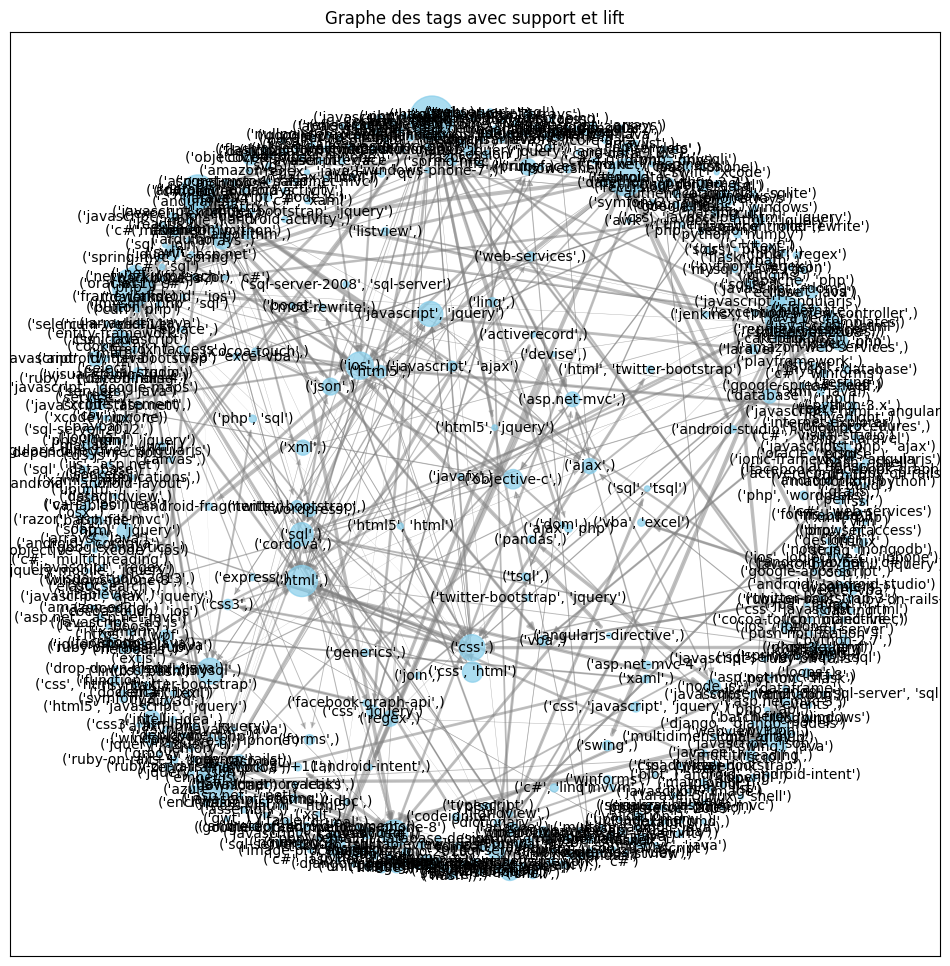

In [5]:
G = nx.DiGraph()
G.clear()
threshold_support = frequent_itemsets['support'].quantile(0)
for index, row in frequent_itemsets.iterrows():
    if row['support'] >= threshold_support:
        itemset = tuple(row['itemsets'])
        G.add_node(itemset, support=row['support'])

for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])
    consequent = tuple(row['consequents'])
    if G.has_node(antecedent) and G.has_node(consequent):
        G.add_edge(antecedent, consequent, weight=row['confidence'], confidence=row['confidence'], lift=row['lift'], leverage=row['leverage'], conviction=row['conviction'], zhang=row['zhangs_metric'])
        # G.add_edge(antecedent, consequent, weight=row['confidence_norm'], confidence=row['confidence'])

node_sizes = [10000 * G.nodes[node]['support'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges]

plt.close()
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Graphe des tags avec support et lift")
plt.savefig('Graph_association_rules2.png')

nx.write_gexf(G, 'graph.gexf')


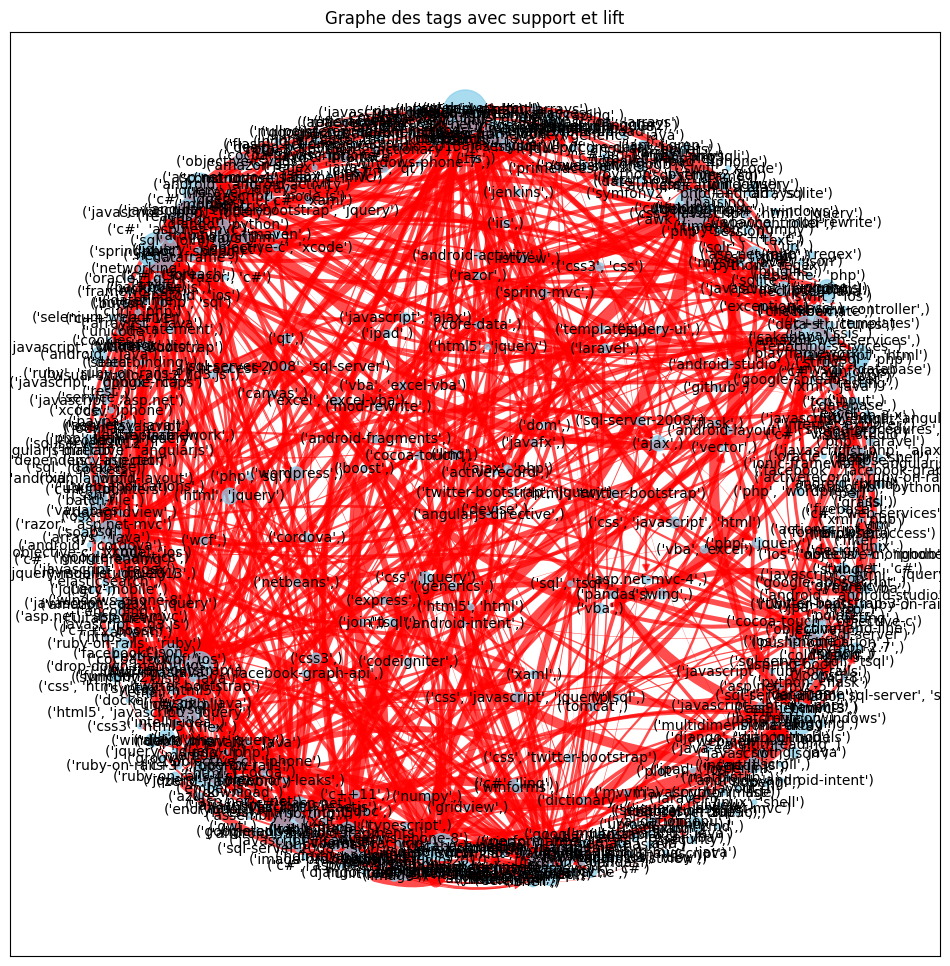

In [6]:
# Other way to plot the graph

G = nx.DiGraph()
G.clear()

list_confidence = rules['confidence'].tolist()
# centrer et normaliser
list_confidence = (list_confidence - np.mean(list_confidence)) / np.std(list_confidence)
rules['confidence_norm'] = list_confidence

# Seuil pour les nœuds
threshold_support = frequent_itemsets['support'].quantile(0)
for index, row in frequent_itemsets.iterrows():
    if row['support'] >= threshold_support:
        itemset = tuple(row['itemsets'])
        G.add_node(itemset, support=row['support'])

# Ajout des arêtes avec vérification de réciprocité
for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])
    consequent = tuple(row['consequents'])
    if G.has_node(antecedent) and G.has_node(consequent):
        G.add_edge(antecedent, consequent, weight=row['confidence_norm'], confidence=row['confidence'])

# Calcul des tailles de nœud et des poids d'arêtes
node_sizes = [10000 * G.nodes[node]['support'] for node in G.nodes]

# Tracé des nœuds
plt.close()
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

eppaiseur = 3

# Tracé des arêtes avec vérification de réciprocité
for u, v in G.edges():
    if G.has_edge(v, u):  # Si une arête inverse existe
        # Tracer le lien réciproque avec une couleur et courbure différentes
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width = eppaiseur * G[u][v]['weight'],  # Ajustement de largeur
            alpha=0.7,
            edge_color="red",  # Couleur différente pour le lien réciproque
            connectionstyle="arc3,rad=0.2"  # Courbure
        )
    else:
        # Tracer les arêtes non réciproques normalement
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width= eppaiseur * G[u][v]['weight'],
            alpha=0.5,
            edge_color="gray"
        )

plt.title("Graphe des tags avec support et lift")
plt.savefig('Graph_association_rules2.png')
plt.show()


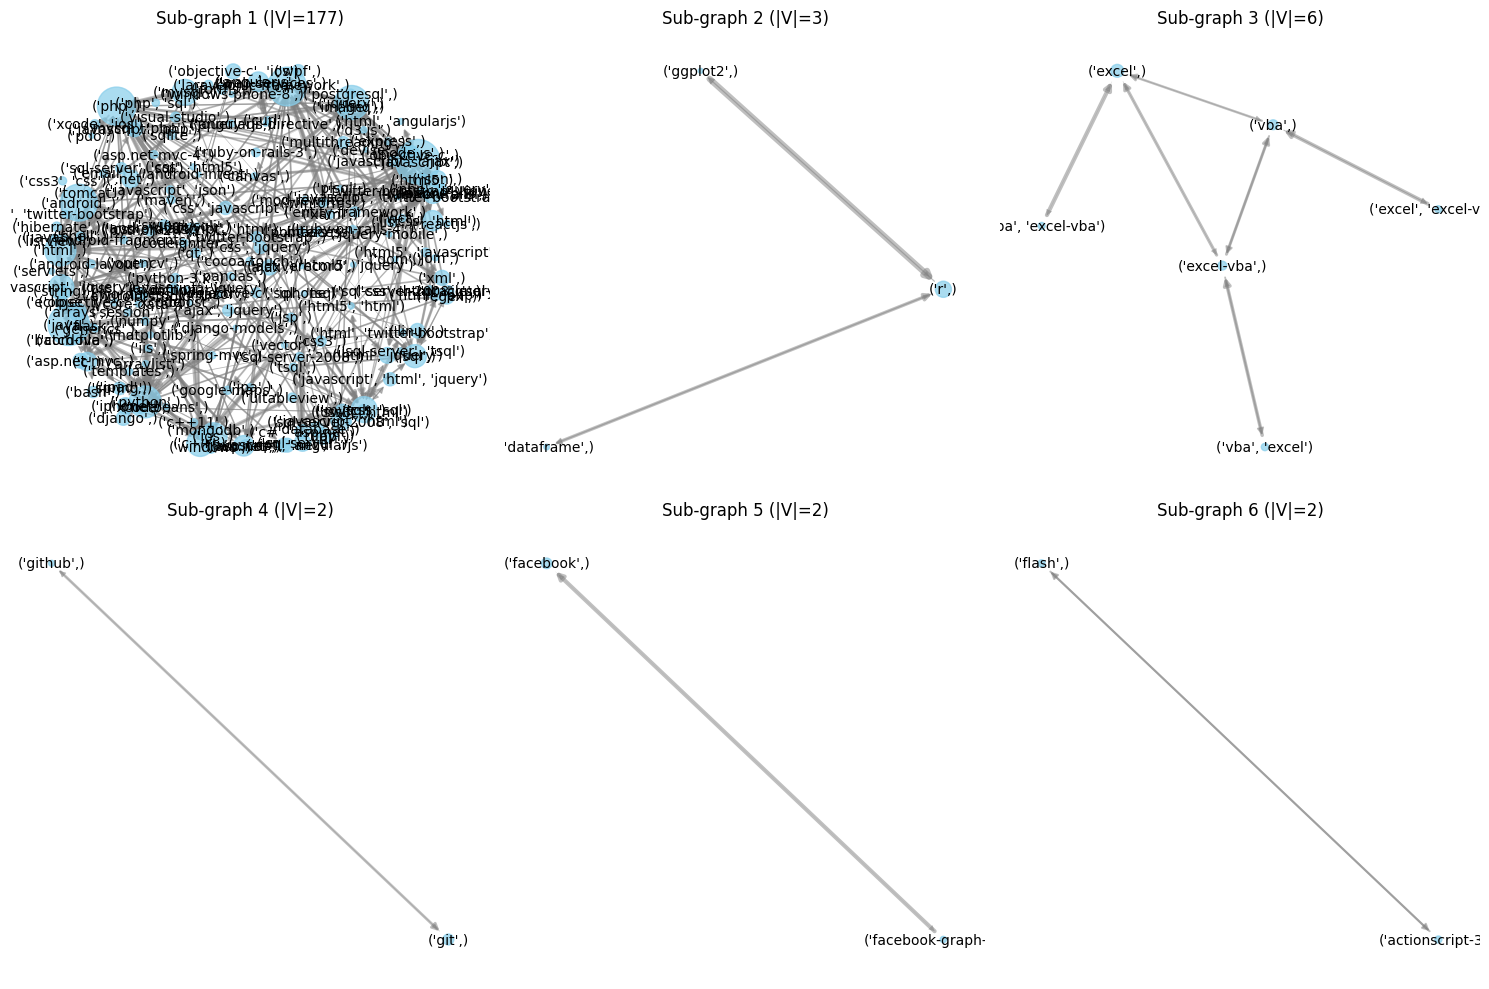

In [7]:
sub_graph = [sub for sub in nx.strongly_connected_components(G) if len(sub) >= 2]

num_subgraphs = len(sub_graph)
cols = 3
rows = math.ceil(num_subgraphs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Draw sub-graphs
for i, sub in enumerate(sub_graph):
    G_sub = G.subgraph(sub)
    nx.write_gexf(G_sub, f'graph_sub_{i}.gexf')

    node_sizes = [10000 * G_sub.nodes[node]['support'] for node in G_sub.nodes]
    edge_weights = [G_sub[u][v]['weight'] * 1.5 for u, v in G_sub.edges]

    pos = nx.spring_layout(G_sub, k=0.5, seed=42)
    ax = axes[i]
    nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes, node_color="skyblue", alpha=0.7)
    nx.draw_networkx_edges(G_sub, pos, ax=ax, width=edge_weights, alpha=0.5, edge_color="gray")
    nx.draw_networkx_labels(G_sub, pos, ax=ax, font_size=10, font_family="sans-serif")
    ax.set_title(f"Sub-graph {i + 1} (|V|={len(G_sub.nodes)})")
    ax.axis('off')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
